In [3]:
!pip install bertopic sentence-transformers umap-learn hdbscan openpyxl
!pip install plotly seaborn scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.5 MB/s eta 0:00:00


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


In [20]:
df = pd.read_excel("Curated.xlsx")

df["text"] = df["Title"].fillna("") + ". " + df["Abstract"].fillna("")
documents = df["text"].tolist()

print("Total documents:", len(documents))


Total documents: 189


In [21]:
embedding_model = SentenceTransformer("allenai/scibert_scivocab_uncased")

embeddings = embedding_model.encode(
    documents,
    batch_size=32,
    show_progress_bar=True
)

print("Embedding shape:", embeddings.shape)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: allenai/scibert_scivocab_uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.decoder.bias               | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Embedding shape: (189, 768)


In [22]:
umap_model = UMAP(
    n_neighbors=15,          # moderate neighborhood size
    n_components=5,          # low-dimensional representation
    min_dist=0.0,            # tighter clustering
    metric="cosine",
    random_state=42
)


In [35]:
umap_model = UMAP(
    n_neighbors=20,
    n_components=5,
    min_dist=0.05,
    metric="cosine",
    random_state=42
)

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=15,     # ← increase this
    min_samples=5,           # ← increase stability
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)


In [36]:
vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(1,2)
)


In [37]:
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(documents, embeddings)


2026-02-18 09:05:03,368 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-18 09:05:03,788 - BERTopic - Dimensionality - Completed ✓
2026-02-18 09:05:03,789 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-18 09:05:03,803 - BERTopic - Cluster - Completed ✓
2026-02-18 09:05:03,805 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-02-18 09:05:03,871 - BERTopic - Representation - Completed ✓


In [38]:
topic_counts = pd.Series(topics).value_counts().sort_index()
print(topic_counts)


-1    56
 0    94
 1    20
 2    19
Name: count, dtype: int64


In [39]:
valid_idx = [i for i, t in enumerate(topics) if t != -1]

if len(set([topics[i] for i in valid_idx])) > 1:
    sil_score = silhouette_score(
        embeddings[valid_idx],
        np.array(topics)[valid_idx]
    )
    print("Silhouette Score:", sil_score)
else:
    print("Not enough clusters for silhouette score.")


Silhouette Score: 0.06632382


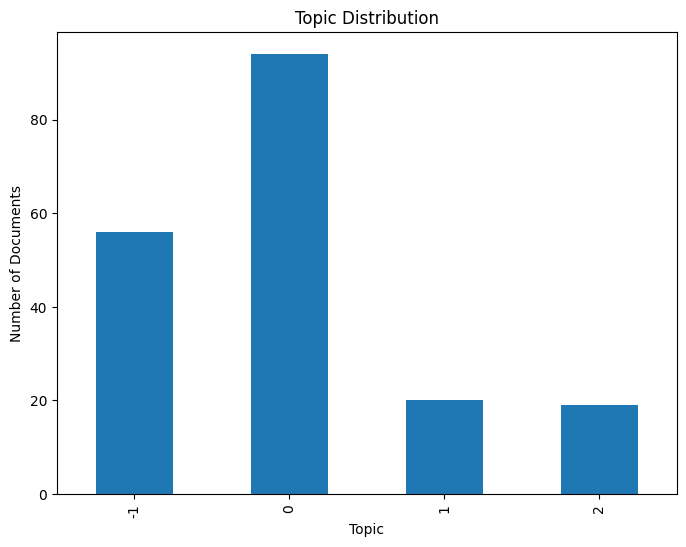

In [40]:
plt.figure(figsize=(8,6))
topic_counts.plot(kind="bar")
plt.title("Topic Distribution")
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.savefig("Figure_1_Topic_Distribution.png", dpi=300)
plt.show()


In [41]:
fig = topic_model.visualize_topics()
fig.write_html("Figure_2_Intertopic_Distance.html")
fig.show()


In [42]:
fig = topic_model.visualize_barchart()
fig.write_html("Figure_3_Keywords.html")
fig.show()


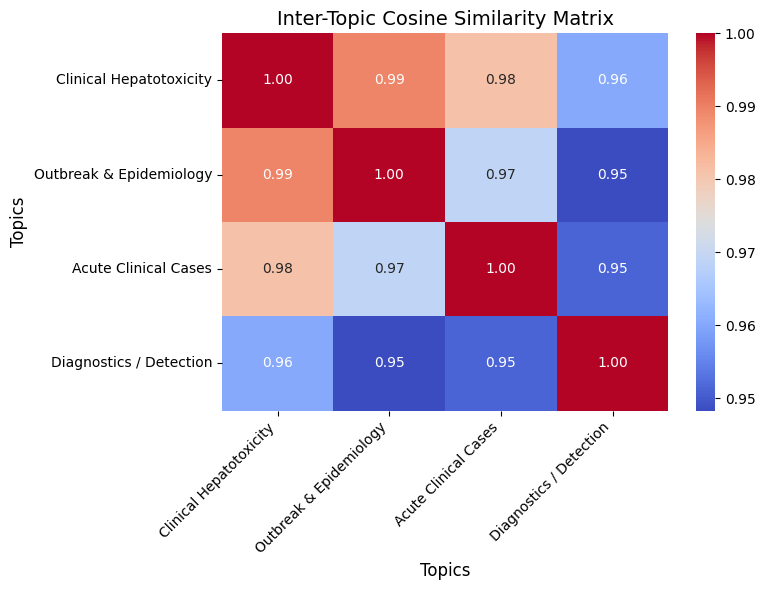

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Get similarity matrix
topic_embeddings = topic_model.topic_embeddings_
similarity_matrix = cosine_similarity(topic_embeddings)

# Define custom topic labels
topic_labels = [
    "Clinical Hepatotoxicity",
    "Outbreak & Epidemiology",
    "Acute Clinical Cases",
    "Diagnostics / Detection"
]

plt.figure(figsize=(8,6))
sns.heatmap(
    similarity_matrix,
    annot=True,
    cmap="coolwarm",
    xticklabels=topic_labels,
    yticklabels=topic_labels,
    fmt=".2f"
)

plt.title("Inter-Topic Cosine Similarity Matrix", fontsize=14)
plt.xlabel("Topics", fontsize=12)
plt.ylabel("Topics", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.savefig("Figure_4_Topic_Similarity_Heatmap.png", dpi=600)
plt.show()


In [44]:
fig = topic_model.visualize_hierarchy()
fig.write_html("Figure_5_Hierarchy.html")
fig.show()


In [45]:
topic_info = topic_model.get_topic_info()
topic_info.to_csv("Table_1_Topic_Summary.csv", index=False)
topic_info


,Topic,Count,Name,Representation,Representative_Docs
0,-1,56,-1_mushroom_poisoning_mushroom poisoning_patients,"[mushroom, poisoning, mushroom poisoning, pati...",[Kinetics of amatoxins in human poisoning: the...
1,0,94,0_poisoning_mushroom_mushroom poisoning_liver,"[poisoning, mushroom, mushroom poisoning, live...",[Amanita bisporigera-Induced Hepatic Failure: ...
2,1,20,1_mushroom_poisoning_mushrooms_outbreaks,"[mushroom, poisoning, mushrooms, outbreaks, ca...",[Sociodemographic differences in the cultural ...
3,2,19,2_patients_poisoning_mushroom_acute,"[patients, poisoning, mushroom, acute, mushroo...",[Scenario of mushroom poisoning in a tertiary ...


In [49]:
df["Topic"] = topics
df.to_csv("01_Final_Dataset_With_Topics.csv", index=False)


In [50]:
df["Topic"] = topics
df.to_csv("01_Final_Dataset_With_Topics.csv", index=False)


In [51]:
topics_dict = topic_model.get_topics()

keyword_data = []

for topic_id, words in topics_dict.items():
    if topic_id != -1:
        for word, weight in words:
            keyword_data.append([topic_id, word, weight])

keywords_df = pd.DataFrame(keyword_data, columns=["Topic", "Keyword", "Weight"])
keywords_df.to_csv("03_Topic_Keywords_Weights.csv", index=False)


In [52]:
from sklearn.metrics.pairwise import cosine_similarity

topic_embeddings = topic_model.topic_embeddings_
similarity_matrix = cosine_similarity(topic_embeddings)

similarity_df = pd.DataFrame(similarity_matrix)
similarity_df.to_csv("04_Topic_Similarity_Matrix.csv", index=False)


In [53]:
umap_2d = UMAP(
    n_neighbors=20,
    n_components=2,
    min_dist=0.05,
    metric="cosine",
    random_state=42
)

reduced_2d = umap_2d.fit_transform(embeddings)

plot_df = pd.DataFrame({
    "UMAP1": reduced_2d[:,0],
    "UMAP2": reduced_2d[:,1],
    "Topic": topics
})

plot_df.to_csv("05_UMAP_2D_Plot_Data.csv", index=False)


In [54]:
probs_df = pd.DataFrame(probs)
probs_df.to_csv("06_Topic_Probabilities.csv", index=False)


In [58]:
from google.colab import files

files.download("Final_Curated_Dataset_With_Topics.csv")
files.download("Table_1_Topic_Summary.csv")
files.download("03_Topic_Keywords_Weights.csv")
files.download("04_Topic_Similarity_Matrix.csv")
files.download("05_UMAP_2D_Plot_Data.csv")
files.download("06_Topic_Probabilities.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>